#Proyecto: visor de noticias actuales#

El proyecto consta de procesos que se darán en el siguiente orden:
- web scrapping
- nlp para identificar lugares mediante NER
- geocódigo para rescatar la ubicación por coordenadas de los lugares.
- encapsular todo mediante django en un visor.

## NLP NER##


In [113]:
#instalamos librerías
!pip install spacy
!pip install pandas
import spacy.cli
import pandas as pd

#instalamos las librerías
!pip install geopandas
!pip install arcgis
!pip install folium

spacy.cli.download("en_core_web_sm")
spacy.cli.download("es_core_news_sm")

     |████████████████████████████████| 901kB 2.9MB/s 
     |████████████████████████████████| 9.8MB 40.8MB/s 
     |████████████████████████████████| 17.9MB 35.2MB/s 
  Created wheel for munch: filename=munch-2.3.2-py2.py3-none-any.whl size=6614 sha256=4b5b5f1260c85f9962291f91e454168c34e2c1c8fd287fa102f85f0667524f54
  Stored in directory: /root/.cache/pip/wheels/db/bf/bc/06a3e1bfe0ab27d2e720ceb3cff3159398d92644c0cec2c125
Successfully built munch
     |████████████████████████████████| 1.4MB 2.8MB/s 
     |████████████████████████████████| 194kB 49.1MB/s 
     |████████████████████████████████| 15.3MB 33.0MB/s 
     |████████████████████████████████| 2.3MB 42.6MB/s 
     |████████████████████████████████| 61kB 23.7MB/s 
     |████████████████████████████████| 102kB 34.5MB/s 
  Created wheel for arcgis: filename=arcgis-1.6.2.post1-py2.py3-none-any.whl size=1722725 sha256=9b5ea9c0f630e60ed50c1691fd8966391ec685e0ef7ccf6ada10f7f0e2619f79
  Stored in directory: /root/.cache/pip/wheels/f7/64

In [0]:
#cargamos el motor de nlp en español
nlp_es = spacy.load('es_core_news_sm')

In [0]:
#definimos el texto a analizar
text = """Esta tarde se reportó el hallazgo de una maleta y bolsas de basura con restos humanos en el interior. El objeto fue abandonado en la cuadra 1 Fausto Castañeta, en inmediaciones de la Plaza de Acho, en el distrito del Rímac.

vecinos de la zona dieron aviso a las autoridades sobre la existencia de una maleta con restos humanos dentro. Se trata de tres piernas y dos brazos que se encuentran en la maleta negra para viaje. 

Además, junto a esto se encuentran dos bolsas negras de plástico con más restos humanos y prendas de vestir, informó la dirección policial de Lima Norte.

En el lugar se hicieron presentes agentes de la Policía Nacional que acordonaron la zona, hasta la llegada de peritos de criminalistíca para el levantamiento de los restos cercenados. 

- Otros puntos -
Este nuevo hallazgo se suma a los dos cuerpos que fueron encontrados en el exterminal de Fiori y a los restos cercenados que se descubrieron en el cruce de las avenidas Izaguirre y Universitaria, en el distrito de San Martín de Porres.

La investigación por el hallazgo de estos cadáveres está a cargo de la Divincri Centro. """
    

In [0]:
doc= nlp_es(text)
datf= dict()
datf["name"]=[]

In [0]:
for entity in doc.ents:
    if entity.label_ == 'LOC':
        datf["name"].append("%s,Lima"%entity.text)

df= pd.DataFrame(datf)

## Geocódigo##

In [0]:
import pandas as pd
import geopandas as gpd
from arcgis.gis import GIS
from arcgis.geocoding import geocode, reverse_geocode
from arcgis.geometry import Point

In [0]:
gis = GIS()
df["x"] = 0
df["y"] = 0
df["Match_addr"] = ""
df["Score"] = ""

data = df[:]
data = data.drop(data.index[:])

def extractAddress(df, indice, idDf, address):
    geocode_result = geocode(address = df.iloc[indice][address], as_featureset=True, max_locations=1)
    
    x = geocode_result.features[0]
    gdpoint = x.as_dict["geometry"]
    attr = x.as_dict["attributes"]
    dataF = data.append(pd.Series([df.iloc[indice][address], gdpoint["x"], gdpoint["y"], attr["Match_addr"], attr["Score"]], index=[idDf, "x", "y", "Match_addr", "Score"] ), ignore_index=True)
    return dataF

In [0]:
for n in range(len(df)):
    data = extractAddress(df, n, "name", "name")

In [128]:
data

,name,x,y,Match_addr,Score
0,"Plaza de Acho,Lima",-77.023270,-12.042070,Plaza Acho,99.97
1,"distrito del Rímac,Lima",-77.032880,-12.029330,"Del Rimac, Rimac, Lima",84.00
2,"Lima Norte,Lima",-77.060440,-11.949630,Lima Norte,100.00
3,"Policía Nacional,Lima",-76.934720,-12.067800,"Policia Nacional, La Molina, Lima",100.00
4,"Fiori,Lima",-77.060070,-12.009820,Fiori,100.00
5,"Izaguirre,Lima",-77.100248,-11.834424,"Pasaje Izaguirre, As. De Pequeños Avicultores ...",97.35
6,"Universitaria,Lima",-77.008274,-11.856758,"Avenida Universitaria, Carabayllo, Lima, 15319",97.35
7,"distrito de San Martín de Porres,Lima",-77.085390,-12.010320,"San Martín de Porres, Lima",87.18
8,"Divincri Centro,Lima",-77.054440,-11.924470,Divincri,80.00


## Visualizamos los lugares encontrados##

In [0]:
import pandas as pd
from geopandas import GeoDataFrame
from shapely.geometry import Point
import fiona

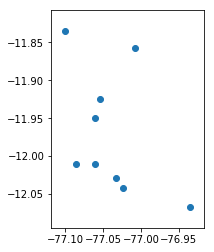

In [130]:
geometry = [Point(xy) for xy in zip(data.x, data.y)]
crs = {'init': 'epsg:4326'} #https://www.spatialreference.org/ref/epsg/4326/ %matplotlib inline
geo_df = GeoDataFrame(data, crs=crs, geometry=geometry)
geo_df.plot()

In [131]:
import folium

gjson = geo_df.to_crs(epsg='4326').to_json()

mapa = folium.Map([-12, -77], zoom_start=11, tiles='openstreetmap')
points = folium.features.GeoJson(gjson)
mapa.add_children(points)
mapa

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
  import sys


In [135]:
from folium.plugins import MarkerCluster
mc = MarkerCluster()
mapa = folium.Map([-12, -77], zoom_start=10, tiles='openstreetmap')
for idx, row in data.iterrows():
    mc.add_child(folium.Marker((row["y"],row["x"]),popup= row["name"]))
mapa.add_child(mc)
mapa
